# Scraping Data Jobs with Python and Selenium

As a data professional, I am always on the hunt for exciting new opportunities. 

I wanted to build a simple webscraper to pu

FIXME: The Indeed scraper is having trouble with company names

### NOTES
1) cool [post](https://towardsdatascience.com/gone-to-find-myself-finding-where-i-am-in-the-data-science-world-by-web-scraping-job-postings-bf416dbfb6fa) about this! 
2) Another cool [post](https://towardsdatascience.com/web-scraping-indeed-com-e5591790736d) more stats/ML based
3) Start super simple and then build your way up. Post a medium article to get something out there!
4) Do a Selenium and Beautiful Soup Version
5) Scrape data, visualize data. 
6) more reading and examples: https://towardsdatascience.com/the-most-in-demand-skills-for-data-scientists-in-2021-4b2a808f4005
7) more reading and examples:https://medium.com/@alex.kirkup/web-scraping-2023-data-science-jobs-listings-to-extract-the-key-skills-required-2359bfab176e

In [2]:
from driver_builder import DriverBuilder
from selenium.webdriver.common.by import By
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from wordcloud import WordCloud
from PIL import Image
import geopandas as gpd
from shapely.geometry import Polygon
# from matplotlib.ticker import FuncFormatter


import logging
import regex as re
from datetime import datetime
import time
from string import punctuation

from lists_and_dicts import state_codes, street_sfx, state_map, buzz_words
from JobScraper import DataJobsScraper, clean_title, get_state_code, PATH
sns.set_style(style="darkgrid")

# dj_site = 'https://datajobs.com/'
# indeed_site = 'https://indeed.com/'
# # this pattern pulls jobs specifically from datajobs
# dj_pattern = r"<a href=\"(.*)\"><strong>(.*)</strong> – <span [^\>]*>(.*)</span></a>[\n\s]*</div>[\n\s]*<div[^\>]*>[\n\s]*<em>[\n\s]*<span[^\>]*>(.*)</span>[\n\s]*[\&nbsp;\•]*[\n\s]*\$*([\d,]*)[–\s]*\$*([\d,]*)[\n\s]*</em>"
# col_list = [
#     'url',
#     'title',
#     'company',
#     'location',
#     'salary_lower',
#     'salary_upper'
# ]


# wait_time = 3
# PATH = '/home/colin/Documents/Code/DS Projects/Wellfound Webscraper/DATA'
# LOG_PATH = '/home/colin/Documents/Code/DS Projects/Wellfound Webscraper/LOGS'
# HEADLESS = False
# WAIT_TIME = 10

# logging.basicConfig(
#     filename=LOG_PATH + "/main.log",
#     format="%(levelname)s - %(asctime)s:%(message)s",
#     encoding="utf-8",
#     level=logging.INFO,
# )

# to look at other styles: plt.style.available
# plt.style.use('seaborn-v0_8-white')

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = 'Ubuntu'
# plt.rcParams['font.monospace'] = 'Ubuntu Mono'


# TODO: Make this work on multiple sites
# TODO: Grab job desciptions as well

### Old code before import

In [ ]:
def cleanhtml(raw_html):
    """To clean up HTML. Removes all HTML tags and comments. Leaves plain text.

    Input:
    ------
        raw_html -> string: html scraped from a website
    Output:
    -------
        cleantext -> string: text from rawhtml with HTML comments and tags removed
    """
    raw_html2 = re.sub("(<!--.*?-->)", "", raw_html, flags=re.DOTALL)
    cleantext = re.sub(
        "<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});", " ", raw_html2
    )
    return cleantext


def remove_style_tags(html_string):
    # Regex pattern to match <style> tags and their content
    style_pattern = re.compile(
        r"<style\b[^<]*(?:(?!<\/style>)<[^<]*)*<\/style>", re.IGNORECASE
    )
    # Remove <style> tags and their content from the HTML string
    cleaned_html = style_pattern.sub("", html_string)
    return cleaned_html


def remove_script_tags(html_string):
    # Regex pattern to match <script> tags and their content
    script_pattern = re.compile(
        r"<script\b[^<]*(?:(?!<\/script>)<[^<]*)*<\/script>", re.IGNORECASE
    )
    # Remove <script> tags and their content from the HTML string
    cleaned_html = script_pattern.sub("", html_string)
    return cleaned_html


class DataJobsScraper:

    def __init__(self, site):

        self._site = site
        self.job_meta = pd.DataFrame(
            columns=[
                "url",
                "title",
                "company",
                "location",
                "salary_lower",
                "salary_upper",
                "job_category",
                "site",
            ]
        )

    def scrape_jobs(self):
        driver_builder = DriverBuilder()
        self._driver = driver_builder.get_driver(
            download_location=PATH, headless=HEADLESS
        )

        if self._site == "DataJobs":
            self._site_url = "https://datajobs.com/"
            # there are two different boards on this website
            self.__scrape_datajobs()
        elif self._site == "Indeed":
            self._site_url = "https://indeed.com/"
            self.__scrape_indeed()
        # just dedup jobs before moving on
        self.job_meta.drop_duplicates(
            subset=self.job_meta.columns.tolist()[:-1], inplace=True
        )
        self.job_meta["job_id"] = self.job_meta.index + 1
        self.job_meta["pull_date"] = datetime.today().strftime(r"%m/%d/%Y")

    def scrape_job_text(self):

        if self._site == "DataJobs":
            job_desc_list = self.__scrape_datajob_desc()
        elif self._site == "Indeed":
            job_desc_list = self.__scrape_indeed_desc()

        self.job_descriptions = pd.DataFrame(job_desc_list)

    def clean_data(self):
        # let's clean up the data a bit
        # I noticed that New York City, NY is just represented as New York City. This doesn't work for pulling out the states later so let's just replace it
        self.job_meta.location = self.job_meta.location.replace(
            {"New York City": "New York City, NY"}
        )
        # This is an HTML code for ampersand. Let's just replace it with an actual ampersand
        self.job_meta["title"] = self.job_meta["title"].replace({"&amp;": "&"})
        # Let's get the states (note, there are non-US jobs in this dataset)
        # self.job_meta['state'] = self.job_meta.loc[:,'location'].fillna('').apply(lambda x: x.replace(' ', '').split(',')[1] if ',' in x else x)
        self.job_meta["state"] = (
            self.job_meta.loc[:, "location"]
            .fillna("")
            .apply(lambda x: get_state_code(x))
        )
        # finally, let's clean up the job titles a bit based on some hard coded rules. This is not fool proof but it gives us a much better idea of what jobs are on this site.
        self.job_meta["clean_title"] = self.job_meta["title"].apply(clean_title)

    def export_data(self, data_path):
        self._driver.close()
        try:
            # grab old data
            old_jm = pd.read_csv(f"{data_path}/{self._site}_job-meta.csv")
            old_jd = pd.read_csv(f"{data_path}/{self._site}_job-descriptions.csv")
        except:
            # TODO: Fix comma issue, maybe just by making things excel files
            self.job_meta.to_csv(f"{data_path}/{self._site}_job-meta.csv", index=False)
            self.job_descriptions.to_csv(
                f"{data_path}/{self._site}_job-descriptions.csv", index=False
            )
        else:
            # set the new indexes
            self.job_meta["job_id"] = self.job_meta["job_id"] + old_jm["job_id"].max()
            self.job_descriptions["job_id"] = (
                self.job_descriptions["job_id"] + old_jd["job_id"].max()
            )

            # drop duplicate jobs
            comb_jm = pd.concat(
                [old_jm, self.job_meta], ignore_index=True
            ).drop_duplicates(
                subset=["url", "title", "company", "location"],
                keep="first",
                ignore_index=True,
            )
            # drop duplicate descriptions. NOTE: This logic will prevent keeping jobs where the poster edited the job posting text
            comb_jd = pd.concat([old_jd, self.job_descriptions], ignore_index=True)
            comb_jd = comb_jd[comb_jd["job_id"].isin(list(comb_jm["job_id"].values))]

            # TODO: Fix comma issue, maybe just by making things excel files
            comb_jm.to_csv(f"{data_path}/{self._site}_job-meta.csv", index=False)
            comb_jd.to_csv(
                f"{data_path}/{self._site}_job-descriptions.csv", index=False
            )

    def __scrape_datajobs(self):
        board_paths = ["/Data-Science-Jobs", "/Data-Engineering-Jobs"]
        # loop through the boards available
        for bp in board_paths:
            if bp == "/Data-Science-Jobs":
                cat = "Data Science & Analytics"
            else:
                cat = "Data Engineering"
            # load into the webpage
            self._driver.get(self._site_url + bp)
            more_pages = True  # will kill the loop when there are no more pages
            i = 0  # just a counter to kill the loop just in case
            while more_pages:
                # grab page source html
                page_html = self._driver.page_source

                # grab job info
                fall = re.findall(dj_pattern, page_html)

                # create pandasable list
                fall_cols = [dict(zip(self.job_meta.columns, x + (cat,))) for x in fall]

                # add to dataframe
                self.job_meta = pd.concat(
                    [self.job_meta, pd.DataFrame(fall_cols)], ignore_index=True
                )

                if i == 200:
                    # stop after 200 pages
                    more_pages = False

                # try to go to next page
                try:
                    next_page = WebDriverWait(self._driver, wait_time).until(
                        EC.element_to_be_clickable(
                            (By.XPATH, "//a[contains(text(), 'NEXT PAGE')]")
                        )
                    )
                    next_page.click()
                    i += 1
                except:
                    print("END OF SEARCH RESULTS...")
                    more_pages = False
        self.job_meta["site"] = self._site_url

    def __scrape_datajob_desc(self):
        job_desc_list = []
        for _, job in self.job_meta.iterrows():
            job_url = self._site_url + job["url"][1:]
            self._driver.get(job_url)
            # grab job desc element
            try:
                job_descr = WebDriverWait(self._driver, wait_time).until(
                    EC.element_to_be_clickable(
                        (
                            By.XPATH,
                            "//div[@id='job_description']//*[@class='jobpost-table-cell-2']",
                        )
                    )
                )
            except:
                print(f"I can't find this job: {job['title']}")
                continue
            # get html
            job_desc_clean = cleanhtml(job_descr.get_attribute("innerHTML"))
            job_desc_list.append(
                {
                    "job_id": job["job_id"],
                    "title": job["title"],
                    "company": job["company"],
                    "desc": job_desc_clean,
                }
            )
        return job_desc_list

    def __scrape_indeed(self):
        # states = ['California', 'Texas', 'Washington State', 'New York', 'Florida', 'Colorado', 'Oregon', 'Illinois', 'Massachusetts']
        states = ["United States"]
        jobs = ["Data Scientist", "Data Analyst", "Data Engineer"]

        # states = ['California']
        # jobs = ['Data Scientist']

        for state in states:
            for job in jobs:

                # we are having a frequest request issue, let's try some rate limiting
                time.sleep(np.random.randint(0, 1) / 10)

                bp = f"jobs?q={job.lower().replace(' ','+')}&l={state}"
                self._driver.get(self._site_url + bp)

                more_pages = True  # will kill the loop when there are no more pages
                i = 0  # just a counter to kill the loop just in case
                while more_pages:

                    # grab page source html
                    page_html = self._driver.page_source

                    # scrape job titles
                    titles = re.findall(
                        "<span[^>]*jobTitle[^>]*>(?<=>)(.*?)(?=<)", page_html
                    )

                    # scrape job links
                    links = re.findall(
                        '<h2[^>]*jobTitle[^>]*><a[^>]*href="([^">]*)">', page_html
                    )

                    clean_links = self.__clean_indeed_link(links=links)

                    # this is just in order to get it into the same format as the DataJobs scraper
                    nan_list = [np.nan for idx in range(len(titles))]
                    job_cats = [job for idx in range(len(titles))]
                    fall = list(
                        zip(
                            clean_links,
                            titles,
                            nan_list,
                            nan_list,
                            nan_list,
                            nan_list,
                            job_cats,
                        )
                    )

                    # create pandasable list
                    fall_cols = [dict(zip(self.job_meta.columns, x)) for x in fall]

                    # add to dataframe
                    self.job_meta = pd.concat(
                        [self.job_meta, pd.DataFrame(fall_cols)], ignore_index=True
                    )

                    if i == 200:
                        # stop after 200 pages
                        more_pages = False

                    # try to go to next page
                    try:
                        next_page = WebDriverWait(self._driver, wait_time).until(
                            EC.element_to_be_clickable(
                                (
                                    By.XPATH,
                                    "//a[contains(@data-testid, 'pagination-page-next')]",
                                )
                            )
                        )
                        next_page.click()
                        i += 1
                    except:
                        print("END OF SEARCH RESULTS...")
                        more_pages = False
            self.job_meta["site"] = self._site_url

    def __scrape_indeed_desc(self):
        job_desc_list = []
        for idx, job in self.job_meta.iterrows():
            # we are having a frequest request issue, let's try some rate limiting
            time.sleep(np.random.randint(1, 15) / 10)

            # for indeed jobs we store the full url here
            self._driver.get(job["url"])

            # get the source html
            page_html = self._driver.page_source
            page_html = remove_script_tags(page_html)
            page_html = remove_style_tags(page_html)
            # strip out the script and styling

            # grab company name
            company_name = re.findall(
                r"data-company-name[^>]*><span[^>]*><a[^>]*>([^<]*)<", page_html
            )

            if len(company_name) == 1:
                self.job_meta.loc[idx, "company"] = company_name[0]
            else:
                print(
                    f"Not the correct number of company names for ID:{job['job_id']} TITLE: {job['title']}. Found: {company_name}"
                )
                company_name = [""]

            # grab salary
            pay = re.findall(
                r"salaryInfoAndJobType[^>]*><span[^>]*>([^<]*)<", page_html
            )

            if len(pay) == 1:
                # makes sure there are numbers in the string and that it isn't empty
                if pay[0].strip() != "" and re.findall(r"\d", pay[0]):
                    pay_range = self.__pay_handler(pay[0])
                    try:
                        self.job_meta.loc[idx, "salary_lower"] = pay_range[0]
                        self.job_meta.loc[idx, "salary_upper"] = pay_range[1]
                    except:
                        self.job_meta.loc[idx, "salary_lower"] = pay_range[0]
            else:
                print(
                    f"Not the correct number of salaries for ID:{job['job_id']} TITLE: {job['title']} Found: {pay}"
                )

            # grab location
            location = re.findall(
                r"jobLocationText[^>]*><div[^>]*><span[^>]*>([^<]*)<", page_html
            )
            # NOTE: There are two different patterns I've found here
            if not location:
                location = re.findall(r"job-location[^>]*>([^<]*)</div", page_html)

            if len(location) == 1 or len(location) == 2:
                self.job_meta.loc[idx, "location"] = location[0]
            else:
                print(
                    f"Not the correct number of locations for ID:{job['job_id']} TITLE: {job['title']}. Found: {location}"
                )

            # grab job description
            try:
                job_descr = WebDriverWait(self._driver, wait_time).until(
                    EC.element_to_be_clickable((By.ID, "jobDescriptionText"))
                )
            except:
                print(f"I can't find this job: {job['title']}")
                continue

            # get html
            job_desc_clean = cleanhtml(job_descr.get_attribute("innerHTML"))
            job_desc_list.append(
                {
                    "job_id": job["job_id"],
                    "title": job["title"],
                    "company": company_name[0],
                    "desc": job_desc_clean,
                }
            )
        return job_desc_list

    def __pay_handler(self, pay_string):

        # split on the dash
        pays = pay_string.split("-")
        # remove all non-numeric characters
        try:
            pays = [float(re.sub(r"[^\d\.]*", "", x)) for x in pays]
        except ValueError:
            print(f"couldn't convert to float: {pay_string}")
        if len(pays) > 2:
            print(f"there are too many pays! {pay_string}")
            return pay_string

        if "year" in pay_string:
            return pays
        elif "month" in pay_string:
            # we only want to return yearly salaries
            return [12 * x for x in pays]
        elif "week" in pay_string:
            return [52 * x for x in pays]
        elif "day" in pay_string:
            return [255 * x for x in pays]
        elif "hour" in pay_string or "hr" in pay_string:
            return [40 * 52 * x for x in pays]
        elif pays[0] > 30_000:
            return pays[0]
        else:
            print(f"Pay error. not sure how to parse: {pay_string}")
            return pay_string

    def __clean_indeed_link(self, links):
        clean_links = []
        for link in links:
            if link.startswith("/rc/clk?"):
                clean_links.append(
                    "https://www.indeed.com/viewjob?" + link[8:].replace("&amp;", "&")
                )
            elif link.startswith("/pagead"):
                clean_links.append(
                    "https://www.indeed.com" + link.replace("&amp;", "&")
                )
            else:
                print(f"We haven't handled this link type: {link[:20]}")
                clean_links.append(link)

        return clean_links


def clean_title(title):
    temp_title = title.lower().replace(" ", "")
    # let's just lump leadership/management positions into one category since we aren't really looking for these
    if (
        "headof" in temp_title
        or "chief" in temp_title
        or "president" in temp_title
        or "director" in temp_title
        or "manager" in temp_title
    ):
        return "Leadership"
    # software engineering is also not quite what we're looking for
    elif "software" in temp_title and (
        "engineer" in temp_title or "developer" in temp_title
    ):
        return "Software Engineer"
    # here we are mapping the standard data positions. Note that job titles can be Data Scientist - Ads or something like that, this helps us just grab the position title
    elif "data" in temp_title:
        if "scientist" in temp_title or "science" in temp_title:
            return "Data Scientist"
        # here we are generalizing a lot of different positions into one. It's ok for a general overview
        # NOTE: This logic will capture the 'Data Science Engineer' role, since Data Engineering tends to be more in demand, I'm ok with that.
        elif (
            "engineer" in temp_title
            or "warehouse" in temp_title
            or "architect" in temp_title
            or "base" in temp_title
        ):
            return "Data Engineer"
        elif "analyst" in temp_title:
            return "Data Analyst"
        else:
            return title
    # BI Engineer could probably be lumped into data analyst if necessary; although, in big companies they can be very different
    elif (
        ("business" in temp_title and "intelligence" in temp_title)
        or ("business" in temp_title and "analyst" in temp_title)
        or "bi " in title.lower()
    ):
        return "BI Engineer"
    # this is highly specific we could probably stand to workshop this a bit
    elif (
        "machine" in temp_title
        and "learning" in temp_title
        and ("engineer" in temp_title or "scientist" in temp_title)
    ):
        return "Machine Learning Engineer"
    # this captures all the analysts not caught in the 'data' step
    elif "analyst" in temp_title:
        return "Data Analyst"
    elif "statistician" in temp_title:
        return "Statistician"
    elif "hadoop" in temp_title:
        return "Data Engineer"
    else:
        return title


def get_state_code(addr):
    if addr != addr or addr is None:
        return None

    # a lot of these have the word "in" in them, let's remove it
    addr = addr.replace(" in ", " ")

    addr_l = re.sub(f"[{punctuation}]", "", addr.lower())
    sfx_idx = []

    for sfx in street_sfx:
        try:
            addr_l.index(f" {sfx.lower()} ")
        except:
            continue
        else:
            sfx_idx.append({sfx: addr_l.index(f" {sfx.lower()} ")})

    if len(sfx_idx) > 1:
        # for the most part, we can just take the max index here
        idx = -1
        for match in sfx_idx:
            temp_idx = list(match.values())[0]
            if temp_idx > idx:
                idx = temp_idx
                sfx_len = len(list(match.keys())[0])
        addr_l_sub = addr_l[idx + sfx_len + 1 :]
        addr_l_sub = addr_l
    elif len(sfx_idx) == 1:
        idx = list(sfx_idx[0].values())[0]
        sfx_len = len(list(sfx_idx[0].keys())[0])
        addr_l_sub = addr_l[idx + sfx_len + 1 :]
    else:
        addr_l_sub = addr_l

    states = []
    for st in state_codes:
        if st.lower() in addr_l_sub.split():
            states.append(st)

    # if we did not find anything, try looking through actual state names
    if not states:
        for st in state_codes:
            if state_map[st].lower() in addr_l_sub:
                states.append(st)

    # finally, if we found a couple codes, check if 'NE' is one of them
    # that probably applies to the street
    # NOTE: no other cardinal directions are state codes
    if len(states) > 1 and "NE" in states:
        states.remove("NE")

    if len(states) > 1:
        print(f"too many states!!!: {addr} || {states}")
    elif len(states) == 1:
        return states[0]
    else:
        return None

### Analysis

In [3]:
scrape_data = False
if scrape_data:

    djs = DataJobsScraper(site='Indeed')
    djs.scrape_jobs()
    djs.scrape_job_text()
    djs.clean_data()
    djs.export_data(data_path=PATH)

# note: we should separate out the 04/01/2024 indeed pulls from just CA and WA
# TODO: be smarter about this merge
indeed_job_meta = pd.read_csv(PATH + "/Indeed_job-meta.csv")
indeed_job_descriptions = pd.read_csv(PATH + "/Indeed_job-descriptions.csv")
dj_job_meta = pd.read_csv(PATH + "/DataJobs_job-meta.csv")
dj_job_descriptions = pd.read_csv(PATH + "/DataJobs_job-descriptions.csv")

In [4]:
job_meta = pd.concat([
    indeed_job_meta.drop('Unnamed: 0', axis=1),
    dj_job_meta
], ignore_index=True)

job_descriptions = pd.concat([
    indeed_job_descriptions.drop('Unnamed: 0', axis=1).merge(indeed_job_meta[['job_id', 'site']], on='job_id', how='left'),
    dj_job_descriptions.merge(dj_job_meta[['job_id', 'site']], on='job_id', how='left')
], ignore_index=True)

# old datajobs entries didn't have this
job_descriptions['site'].fillna('https://datajobs.com/',inplace=True)

In [5]:
job_meta.head()

,url,title,company,location,salary_lower,salary_upper,job_category,site,job_id,pull_date,state,clean_title
0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,DIRECTOR - CAPITAL MODELING,NaN,"Des Moines, IA",NaN,NaN,Data Scientist,https://indeed.com/,3531,04/08/2024,IA,Leadership
1,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"Oracle Analytics &amp; AI, Manager",NaN,"Chase Tower, 111 Monument Circle Suite 4200, I...",NaN,NaN,Data Scientist,https://indeed.com/,3532,04/08/2024,IN,Leadership
2,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Data Scientist,NaN,NaN,103565.5,124724.04,Data Scientist,https://indeed.com/,3533,04/08/2024,NaN,Data Scientist
3,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Data Scientist – NLP,NaN,"Solytics Partners LLC in New York, NY 10001",90000.0,120000.0,Data Scientist,https://indeed.com/,3534,04/08/2024,NY,Data Scientist
4,https://www.indeed.com/viewjob?jk=153b2d9a0e6c...,Data Scientist,NaN,"Boston, MA",NaN,NaN,Data Scientist,https://indeed.com/,3535,04/08/2024,MA,Data Scientist


In [6]:
# FIXME: fix this
job_meta['state'] = job_meta['location'].apply(lambda x: get_state_code(addr = x))
job_meta['clean_title'] = job_meta['title'].apply(lambda x: clean_title(x))
job_meta.head()


too many states!!!: 40 Court St FL 10, Boston, MA 02108 || ['FL', 'MA']
too many states!!!: AK Group New York, NY 10010 || ['AK', 'NY']
too many states!!!: West Virginia || ['VA', 'WV']
too many states!!!: 30 Winter St FL 12, Boston, MA 02108 || ['FL', 'MA']


,url,title,company,location,salary_lower,salary_upper,job_category,site,job_id,pull_date,state,clean_title
0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,DIRECTOR - CAPITAL MODELING,NaN,"Des Moines, IA",NaN,NaN,Data Scientist,https://indeed.com/,3531,04/08/2024,IA,Leadership
1,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"Oracle Analytics &amp; AI, Manager",NaN,"Chase Tower, 111 Monument Circle Suite 4200, I...",NaN,NaN,Data Scientist,https://indeed.com/,3532,04/08/2024,IN,Leadership
2,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Data Scientist,NaN,NaN,103565.5,124724.04,Data Scientist,https://indeed.com/,3533,04/08/2024,None,Data Scientist
3,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Data Scientist – NLP,NaN,"Solytics Partners LLC in New York, NY 10001",90000.0,120000.0,Data Scientist,https://indeed.com/,3534,04/08/2024,NY,Data Scientist
4,https://www.indeed.com/viewjob?jk=153b2d9a0e6c...,Data Scientist,NaN,"Boston, MA",NaN,NaN,Data Scientist,https://indeed.com/,3535,04/08/2024,MA,Data Scientist


In [7]:
print(f"Unable to parse state codes out of {job_meta[job_meta.state.isin(['',None])].shape[0]/job_meta.shape[0]:.2%} of records.")

Unable to parse state codes out of 9.64% of records.


### some styling options

1) https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08


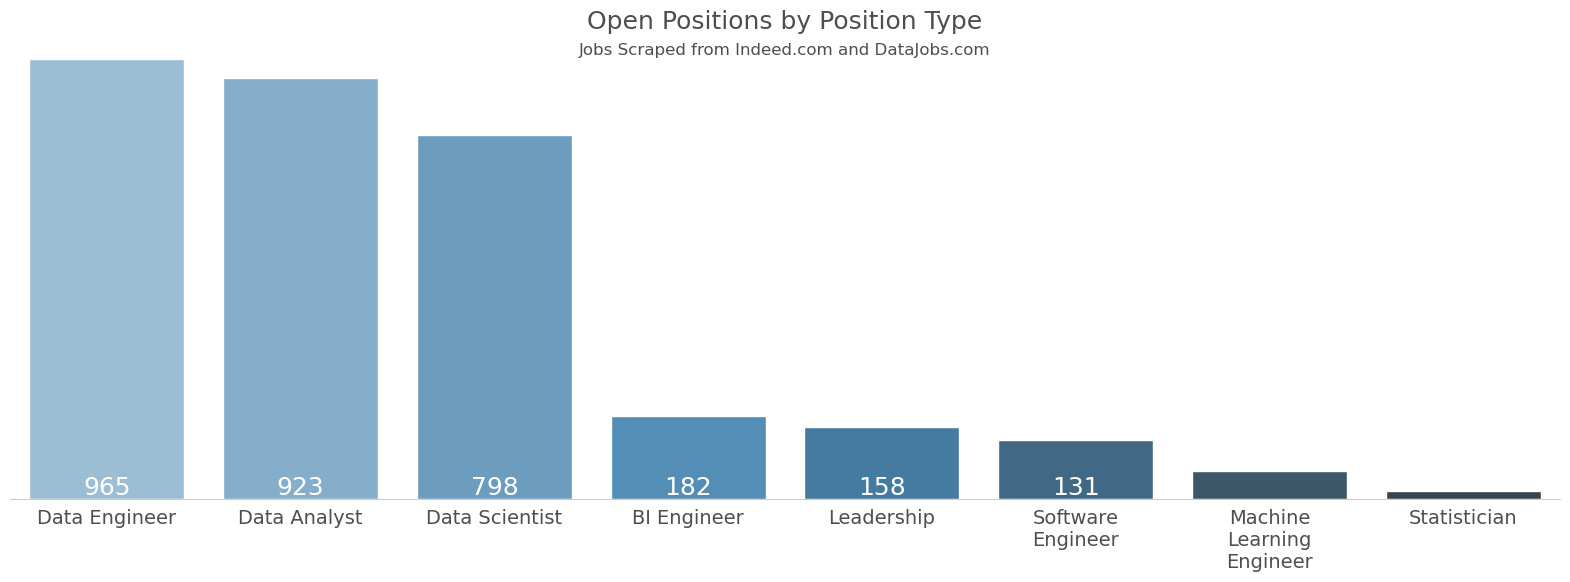

In [8]:
sns.set_style("whitegrid")
# when you're ready to export uncomment this for a sharper image
# plt.rcParams['figure.dpi'] = 360

f, ax = plt.subplots(figsize=(20,6))
# there are a lot of duplicates accross the categories
clean_title_counts = job_meta['clean_title'].value_counts().reset_index()

# Plot the cats
sns.set_color_codes("pastel")
sns.barplot(x='clean_title', y="count", data=clean_title_counts[clean_title_counts['count'] > 1].head(8),
            label="Number of Jobs per Category", palette="Blues_d", ax = ax)
sns.despine(left=True)
# ax.bar_label(ax.containers[0]);

for idx, lbl in enumerate(list(ax.containers[0])):
    h = int(lbl.get_height())
    if h >100:
        plt.text(x=idx, y=10, s=f"{int(lbl.get_height())}", color='white',fontsize=18, horizontalalignment='center')


# ax.set_ylabel('Number of Positions', size=18, color='#4f4e4e');
ax.set_ylabel('')
ax.set_xlabel('');
ax.set_title(f'Open Positions by Position Type', size=18, color='#4f4e4e');
plt.text(x=3.5, y=975, s='Jobs Scraped from Indeed.com and DataJobs.com', 
                 color='#4f4e4e', fontsize=12, horizontalalignment='center')
plt.xticks(size=14, color='#4f4e4e');
# plt.yticks(size=14, color='#4f4e4e');
plt.yticks([],[]);

# let's fix the MLE text
labels = [item.get_text() for item in ax.get_xticklabels()]
for idx, label in enumerate(labels):
    if len(label) > 14:
        labels[idx] = '\n'.join(label.split())

ax.set_xticklabels(labels = labels);

plt.savefig('FIGS/position_types.png');

### Visualize the Number of Jobs in each State
Let's start with just a simple bar chart that lists the state and the number of jobs.

<Axes: xlabel='job_count', ylabel='state'>

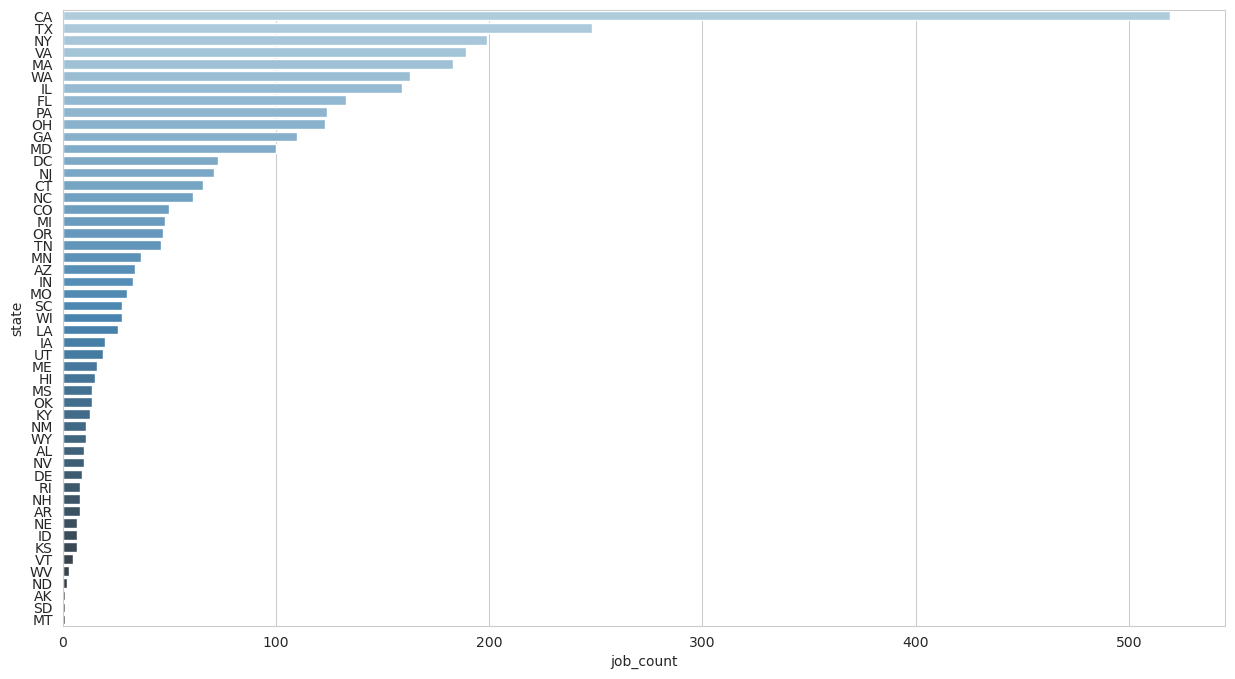

In [9]:

# do a geospatial map for this
# https://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6
f, ax = plt.subplots(figsize=(15,8))
num_states = job_meta[job_meta['state'].isin(state_codes)]['state'].value_counts().reset_index().sort_values(by="count", ascending=False).rename({'count':'job_count'}, axis=1)
# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(y='state', x="job_count", data=num_states,

            label="Alcohol-involved", palette="Blues_d", ax = ax, orient='h')

In [10]:
gdf1 = gpd.read_file('./SHAPES/cb_2018_us_state_500k')
gdf = gdf1.merge(num_states,left_on='STUSPS',right_on='state', how='left')
gdf.job_count.fillna(0, inplace=True)
# gdf.to_crs({'init':'epsg:2163'})
gdf = gdf[gdf.STUSPS.isin(state_codes)]

# Apply this to the gdf to ensure all states are assigned colors by the same func
def makeColorColumn(gdf,variable,vmin,vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Blues)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf


/home/colin/miniconda3/envs/wellfound/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_17090/1653854892.py:83: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'].values[0], linewidth=0.8,ax=hiax, edgecolor='0.8')


<Axes: >

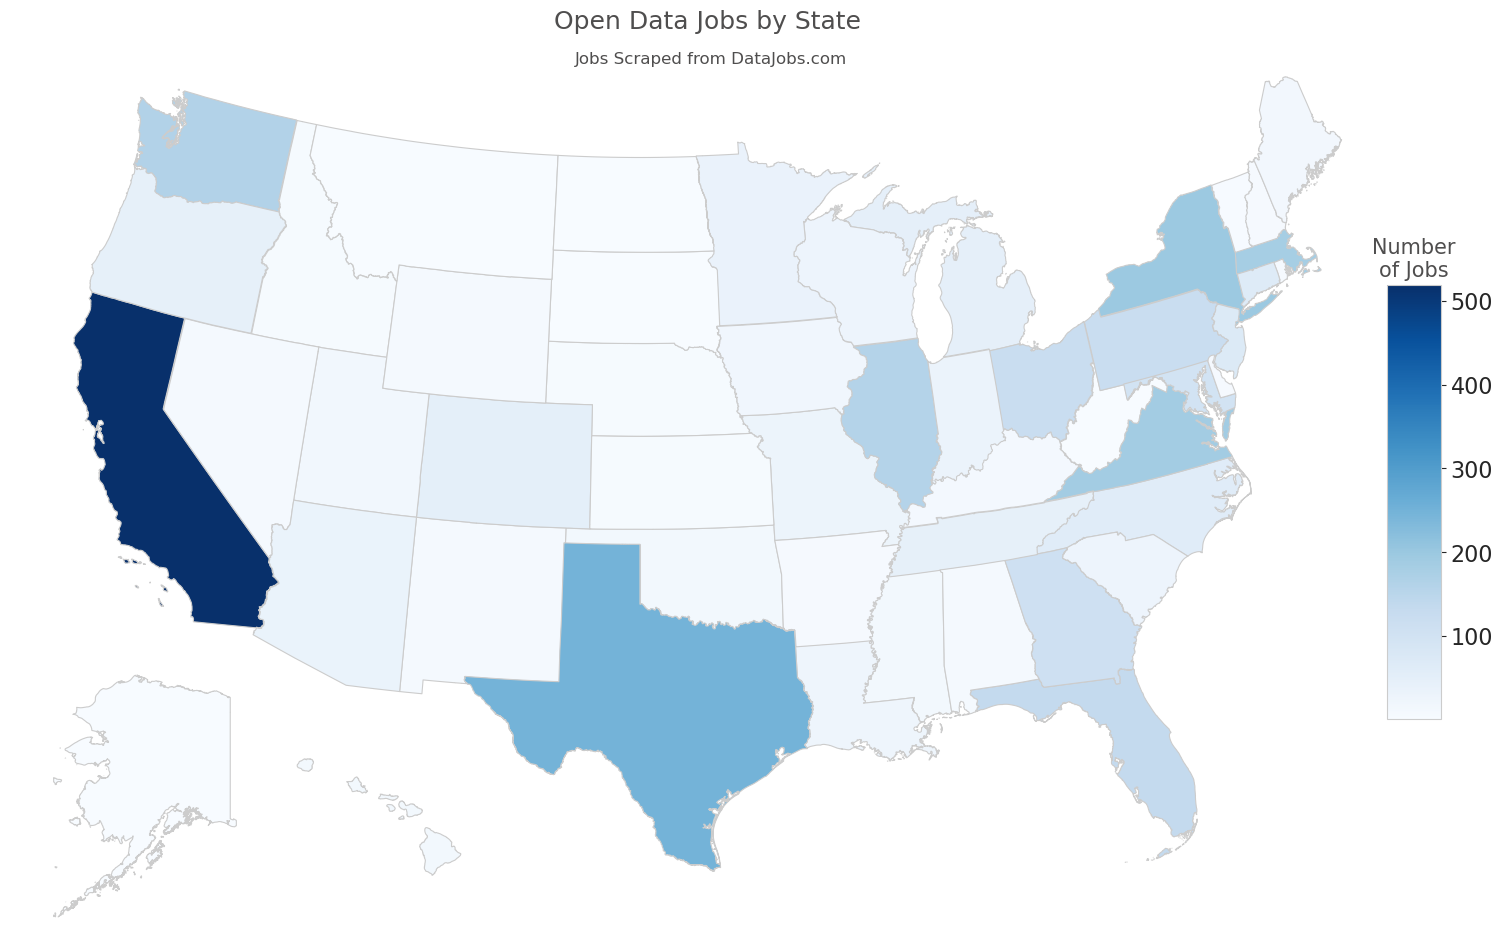

In [11]:
# **************************
# set the value column that will be visualised
variable = 'job_count'
state_var = 'STUSPS'

# make a column for value_determined_color in gdf
# set the range for the choropleth values with the upper bound the rounded up maximum value
vmin, vmax = gdf[variable].min(), gdf[variable].max() #math.ceil(gdf.pct_food_insecure.max())
# Choose the continuous colorscale "YlOrBr" from https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap = "Blues"
gdf = makeColorColumn(gdf,variable,vmin,vmax)

# create "visframe" as a re-projected gdf using EPSG 2163 for CONUS
visframe = gdf.to_crs({'init':'epsg:2163'})



# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box around the vis
ax.axis('off')

# set the font for the visualization to Helvetica
# hfont = {'fontname':'Helvetica'}

# add a title and annotation
ax.set_title('Open Data Jobs by State', size=18, color='#4f4e4e');
ax.annotate('Jobs Scraped from DataJobs.com', xy = (0.395,0.625) , xycoords='figure fraction',
                 color='#4f4e4e', fontsize=12, horizontalalignment='center')
# Create colorbar legend
fig = ax.get_figure()
# add colorbar axes to the figure
# This will take some iterating to get it where you want it [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.89, 0.32, 0.03, 0.31])   

cbax.set_title('Number\nof Jobs', size=15, color='#4f4e4e')

# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=plt.Normalize(vmin=vmin, vmax=vmax))
# reformat tick labels on legend
sm._A = []
# comma_fmt = FuncFormatter(lambda x, p: format(x/100, '.0%'))
fig.colorbar(sm, cax=cbax)
tick_font_size = 16
cbax.tick_params(labelsize=tick_font_size)

# annotate the data source, date of access, and hyperlink
# ax.annotate("Data: Scraped from https://datajobs.com/", xy=(0.22, .085), xycoords='figure fraction', fontsize=14, color='#555555')


# create map
# Note: we're going state by state here because of unusual coloring behavior when trying to plot the entire dataframe using the "value_determined_color" column
for idx, row in visframe.iterrows():

    if row[state_var] not in ['AK','HI']:
        try:
            vf = visframe[visframe[state_var]==row[state_var]]
            c = gdf[gdf[state_var]==row[state_var]][0:1].value_determined_color.item()
        except:
            print(vf, gdf[gdf[state_var]==row[state_var]][0:1][['STUSPS', 'value_determined_color']], sep='\n'*2) 
        else:
            vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')



#add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf[state_var]=='AK']
alaska_gdf.clip(polygon).plot(color=gdf[gdf[state_var]=='AK'].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf[state_var]=='HI']
hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'].values[0], linewidth=0.8,ax=hiax, edgecolor='0.8')



In [12]:
buzz_word_counts = {kwd:0 for kwd in buzz_words if kwd not in ('scikitlearn', 'scikit learn', 'Power-BI', 'Power BI', 'Time Series','A-B Testing','AB Testing', 'Amazon Web Services', 'Google Cloud Platform', 'Webscrap')}
buzz_word_counts['Webscraping'] = 0

job_descriptions['naiive_keywords'] = None

for idx, row in job_descriptions.iterrows():
    bw_list = []
    # note: I am purposefully excluding '-' here for hyphen words like 'c-span'. we do not want that to match on 'c'
    desc2 = ' ' + re.sub(r'[^A-Za-z0-9-\+#]+', ' ', row['desc']).lower() + ' '
    for kwd in buzz_words:
        kwd2 = ' ' + kwd.lower() + ' '
        # adding spaces here prevents us from matching on subsets of words. e.g matching on the 'c' in 'coin'
        if kwd2 in desc2: 
            if kwd in ('scikit-learn', 'scikitlearn', 'scikit learn'):
                buzz_word_counts['scikit-learn'] += 1
                bw_list.append('scikit-learn')
            elif kwd in ('PowerBI', 'Power-BI', 'Power BI'):
                buzz_word_counts['PowerBI'] += 1
                bw_list.append('PowerBI')
            elif kwd in ('Time Series', 'Time-Series'): 
                buzz_word_counts['Time-Series'] += 1
                bw_list.append('Time-Series')
            elif kwd in ('A/B Testing','A-B Testing','AB Testing'):
                buzz_word_counts['A/B Testing'] += 1
                bw_list.append('A/B Testing') 
            elif kwd == 'Google Cloud Platform':
                buzz_word_counts['GCP'] += 1
                bw_list.append('GCP')  
            elif kwd == 'Amazon Web Services':
                buzz_word_counts['AWS'] += 1
                bw_list.append('AWS') 
            elif kwd == 'Webscrap':
                buzz_word_counts['Webscraping'] += 1
                bw_list.append('Webscraping')                              
            else:     
                buzz_word_counts[kwd] += 1
                bw_list.append(kwd)
    job_descriptions.loc[idx, 'naiive_keywords'] = ', '.join(bw_list)

sorted_bw_count = {}
for w in sorted(buzz_word_counts, key=buzz_word_counts.get, reverse=True):
    sorted_bw_count[w] = buzz_word_counts[w]

In [13]:
sorted_bw_count

{'SQL': 1763,
 'Python': 1704,
 'Machine Learning': 1013,
 'R': 829,
 'Visualization': 747,
 'AWS': 702,
 'Excel': 686,
 'Tableau': 580,
 'Spark': 485,
 'Azure': 432,
 'Java': 390,
 'Power Bi': 327,
 'Snowflake': 313,
 'Hadoop': 304,
 'SAS': 291,
 'GCP': 251,
 'Deep Learning': 247,
 'NoSQL': 236,
 'Scala': 227,
 'Linux': 202,
 'Javascript': 201,
 'Oracle': 196,
 'Tensorflow': 193,
 'C': 181,
 'Pytorch': 178,
 'C++': 167,
 'Kubernetes': 157,
 'Airflow': 157,
 'pandas': 155,
 'Docker': 141,
 'numpy': 133,
 'PowerBI': 127,
 'MySQL': 124,
 'Time-Series': 117,
 'C#': 95,
 'Unix': 94,
 'Cassandra': 93,
 'scikit-learn': 91,
 'PostgreSQL': 79,
 'MongoDB': 73,
 'keras': 61,
 'Perl': 60,
 'matplotlib': 54,
 'PHP': 50,
 'LLM': 38,
 'Causal Inference': 34,
 'scipy': 32,
 'CNN': 30,
 'Recommender': 21,
 'plotly': 20,
 'Google Sheets': 19,
 'shiny': 18,
 'seaborn': 15,
 'A/B Testing': 13,
 'Julia': 7,
 'LSTM': 7,
 'RNN': 4,
 'Webscraping': 0}

/home/colin/miniconda3/envs/wellfound/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

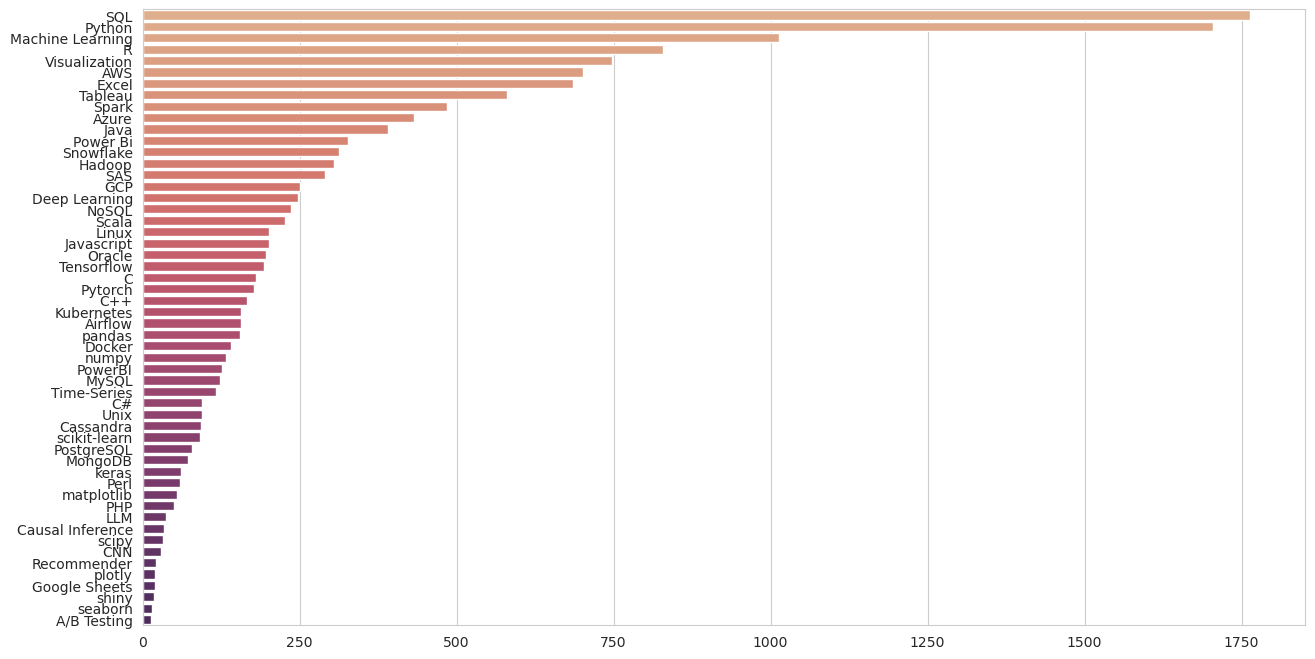

In [14]:
# Plot the crashes where alcohol was involved

viz_counts = {k:v for k, v in sorted_bw_count.items() if v >=10}

f, ax = plt.subplots(figsize=(15,8))
sns.set_color_codes("muted")
sns.barplot(y=list(viz_counts.keys()), x=list(viz_counts.values()), palette="flare", ax=ax, orient='h')

### Some More Advanced Viz.

1) Word Cloud
2) 

In [15]:
# let's try it with removing stop words
from nltk.corpus import stopwords

# Create a set of stop words 
stop_words = set(stopwords.words('english'))
stop_words.update([
    'team',
    'provde',
    'will',
    'year',
    'working',
    'work',
    'experience',
    'provide',
    'management',
    'including',
    'project',
    'develop',
    'development',
    'need',
    'drive',
    'using',
    'build',
    'service',
    'e',
    'g',
    'etc',
    'use',
    'within',
    'well',
    'ability',
    'needs',
    'based',
    'must',
    'level',
    'various',
    'include',
    'group',
    'year',
    'staff',
    'position',
    'area',
    'new',
    'data',
    'preferred qualification',
    'related field',
    'sexual orientation'
]) 

buzz_word_counts2 = {kwd:0 for kwd in buzz_words}

job_descriptions['desc_stop_rem'] = ''

for idx, row in job_descriptions.iterrows():
    word_tokens = re.sub(r'[^A-Za-z0-9-\+#]+', ' ', row['desc']).split()
    job_descriptions.loc[idx, 'desc_stop_rem'] = ' '.join([w.lower() for w in word_tokens if not w.lower() in stop_words])
    

In [16]:
def create_word_cloud(job_type = '', savefig = False):
    if job_type != '':
        df = job_descriptions[job_descriptions['job_id'].isin(job_meta[job_meta.clean_title == job_type]['job_id'])]
    else:
        df = job_descriptions

    wordcloud = WordCloud(background_color = 'white', 
                          max_words = 100, 
                          height = 400, 
                          width = 1000, 
                          colormap='Blues_r', 
                          min_word_length = 3).generate(' '.join(df['desc_stop_rem']))


    f, ax = plt.subplots(figsize=(15,8))
    # Display the generated image:
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")

    if savefig:
        pass

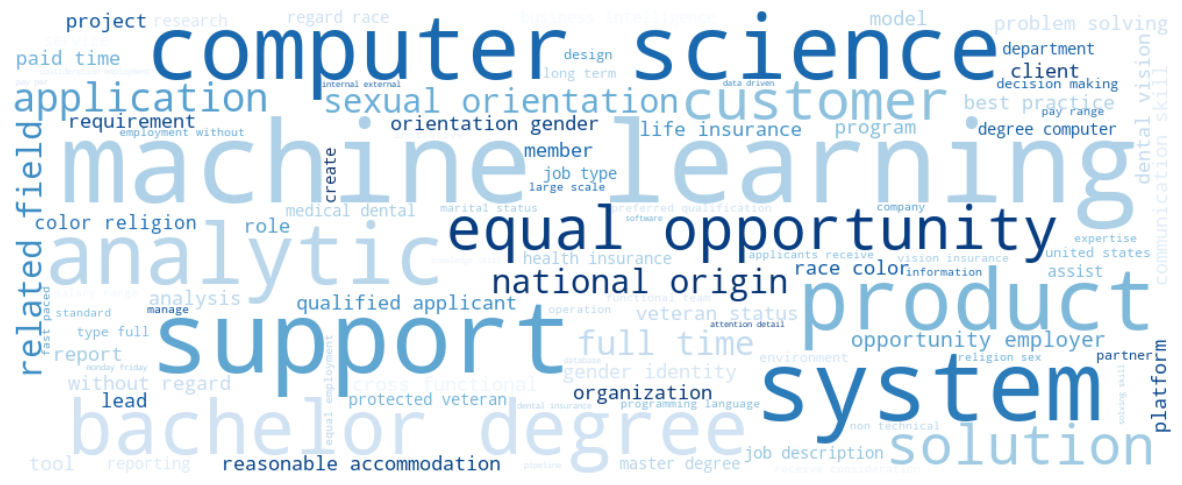

In [17]:
create_word_cloud()

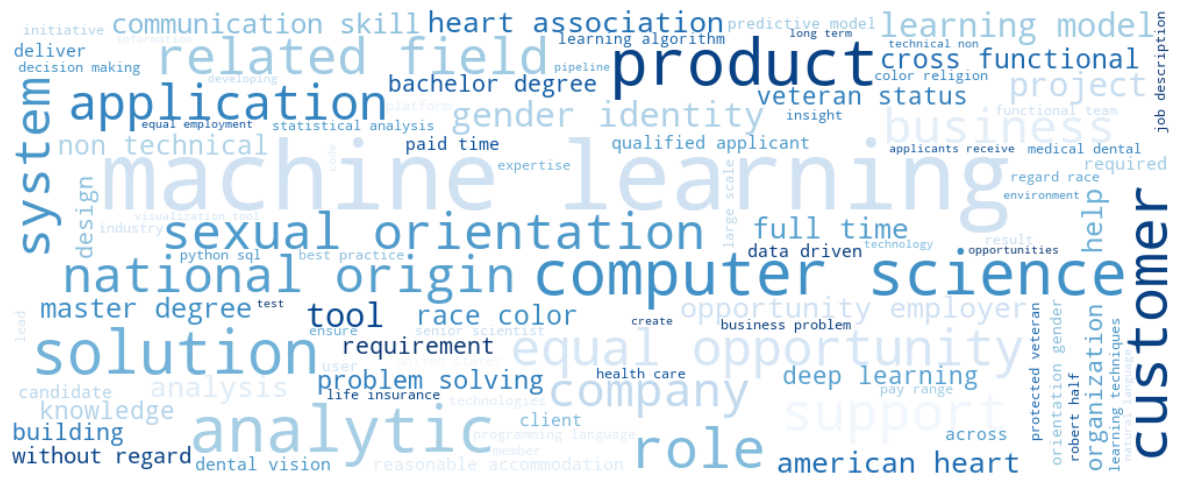

In [18]:
create_word_cloud(job_type='Data Scientist')

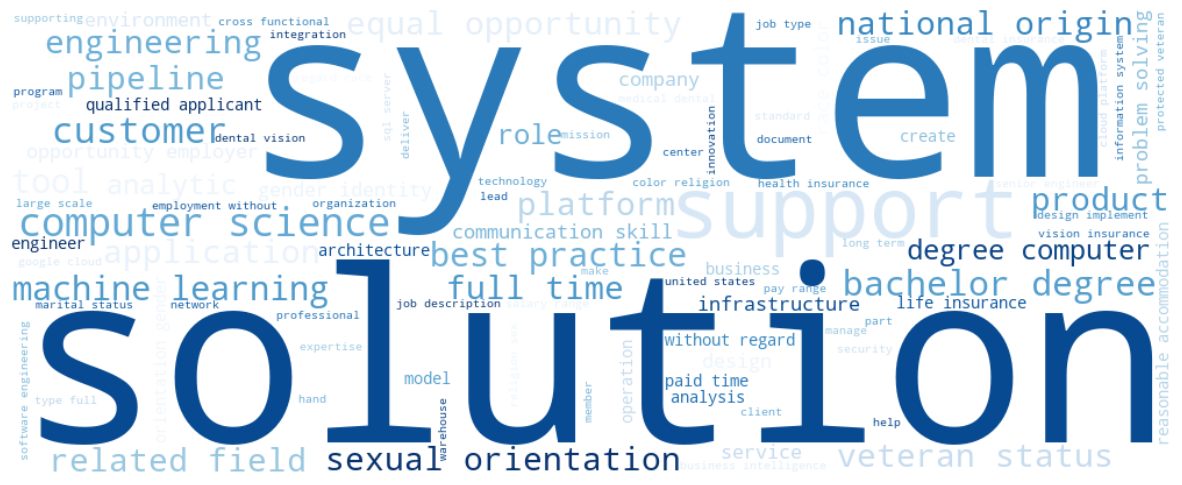

In [19]:
create_word_cloud(job_type='Data Engineer')

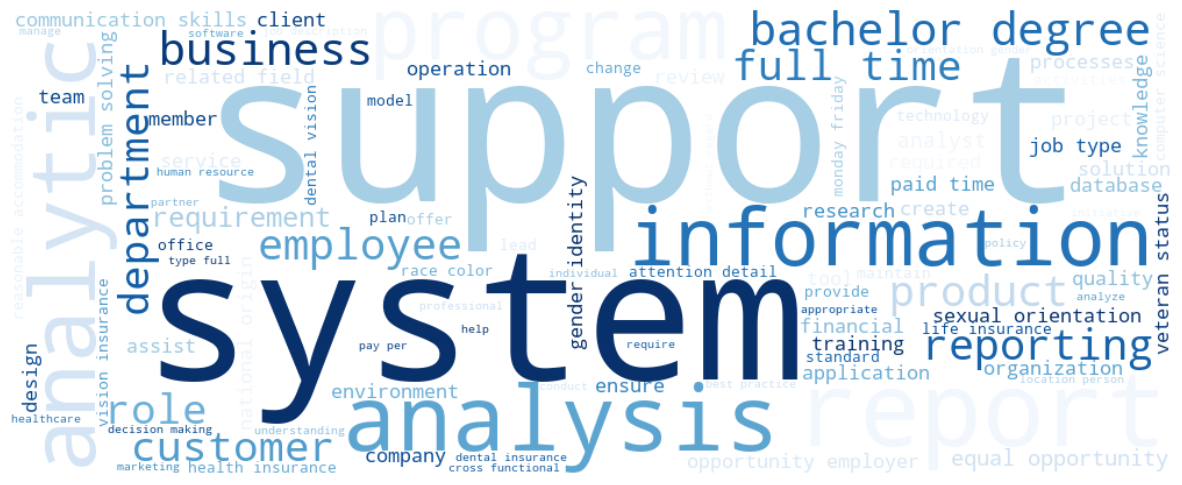

In [20]:
create_word_cloud(job_type='Data Analyst')

### A Better Word Cloud

These word clouds are pretty good. They can give us some nice general insight into these positions and what they might entail. For instance, I can see that there are some general data science buzz words popping up in these job postings like "Machine Learning" and "Visualization". However, these sorts of word clouds do not give us much insight into what tools and soft skills are required for these roles. Since I am looking to improve my marketability, I want to know what employers are looking for when hiring new candidates. A better way to accomplish this is to count the instances of *specific* words and phrases in these job descriptions. Then we can gather up these counts into a cleaner visualization that accounts for the type of word/phrase. First, let's define some lists of words we want to consider.

NOTE: I got some ideas from here: https://www.ischool.berkeley.edu/news/2019/word-clouds-we-cant-make-them-go-away-so-lets-improve-them

In [21]:
# NOTE: We aren't including Go as it is hard to distinguish it from the regular word.
# TODO: try to find that analyst influencers tool to add some stuff to this
programming_languages = [
    'C', 'C++', ' C#', 'Python', 'Scala', 'Java', 'Javascript', 'Julia', 'R', 'Fortran', 'Visual Basic', 'SQL', 'PHP', 'MATLAB', 'Mathematica', 'Ruby', 'Perl', 'Rust', 'SAS', 'COBOL', 'Lisp', 'Stata'
]

libraries = [
    'NumPy', 'Matplotlib', 'Pandas', 'Scikit-learn', 'TensorFlow', 'Seaborn', 'Keras', 'PyTorch', 'SciPy', 'Plotly',  'BeautifulSoup', 'Selenium', 'Scrapy', 'Ggplot2', 'Statsmodels', 'Bokeh', 'NLTK', 'LightGBM', 'Pandas',
    'ELI5', 'XGBoost', 'CatBoost', 'Optuna', 'PyCaret', 'Dplyr', 'Caret', 'randomForest', 'Kernlab', 'Rpart', 'DataExplorer', 'PyCaret'
]

dev_tools = [
    'Azure', 'AWS', 'GCP', 'Apache Spark', 'Apache Airflow', 'Hadoop', 'MapReduce', 'Excel', 'Databricks', 'Coudera', 'ChatGPT', 'Git', 'Github'
]

viz_tools = [
    'Tableau', 'PowerBI', 'Infogram', 'Qlik', 'Looker', 'Zoho Analytics'
]

databases = [
    'PostgreSQL', 'Snowflake', 'Cassandra', 'Oracle', 'MySQL', 'SQL Server', 'MongoDB', 'redis', 'Teradata', 'SQLite', 'IBM Db2'
]

soft_skills = [
    'Presentation', 'Communication', 'Collaboration', 'Adaptability','Project Management', 'Teamwork', 'Attention to detail', 
    'Problem Solving', 'Critical Thinking', 'Continuous Learning', 'Agile', 'Independence', 'Creativity'
]

concepts = [
    'Webscraping', 'Machine Learning', 'Deep Learning', 'CNN', 'ANN', 'ARIMA', "LSTM", 
    'RNN', 'Neural Network', 'Regression', 'Classification', 'Reinforcement Learning', 'Time-Series', 'Supervised Learning', 'Unsupervised Learning',
    'Semi-Supervised Learning', 'Computer Vision', 'Transformer', 'Autoencoder', 'Outlier Detection', 'Artificial Intelligence', 'Large Language Model', 'causal inference', 
    'A/B Testing', 'Recommender System', 'Forecasting'
]

In [22]:
def kw_counter(text, kws):
    kws_counts = {}
    for kw in kws:
        kws_counts[kw] = 0
        if kw == 'Scikit-learn':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' scikitlearn ')
            kws_counts[kw] += text.lower().count(' scikit learn ')
            kws_counts[kw] += text.lower().count(' sci kit learn ')
        elif kw == 'PowerBI':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' Power-BI ')
            kws_counts[kw] += text.lower().count(' Power BI ')
        elif kw == 'Time-Series':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' time series ')
        elif kw == 'A/B Testing':
            # kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' a/b test')
            kws_counts[kw] += text.lower().count(' ab test')
            kws_counts[kw] += text.lower().count(' a-b test')
        elif kw == 'GCP':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' google cloud ')
        elif kw == 'AWS':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' amazon web services ')
        elif kw == 'Webscraping':
            # kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' webscrap')
            kws_counts[kw] += text.lower().count(' web scrap ')
        elif kw =='CNN':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' convolutional neural network ')
        elif kw == 'ANN':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' artificial neural network ')
        elif kw == 'RNN':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' recurrent neural network ')
        elif kw == 'LSTM':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' long-term short-term memory ')
            kws_counts[kw] += text.lower().count(' long term short term memory ')
        elif kw == 'Semi-Supervised Learning':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' semi supervised learning ')
        elif kw == 'Forecasting':
            # kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' forecast')
        elif kw == 'Presentation':
            # kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' present')
        elif kw == 'Communication':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' communicate ')
        elif kw == 'Collaboration':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' collaborate ')
        elif kw == 'Adaptability':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' adapt ')
            kws_counts[kw] += text.lower().count(' adaptable ')
        elif kw == 'Independence':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' independent ')
        elif kw == 'Creativity':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' creative ')
        else:
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
    
    return kws_counts



Now that we have defined some keywords we want to search for, let's count them in our list of descriptions. Let's first visualize just using a static matplotlib visualizer...

(-0.5, 511.5, 511.5, -0.5)

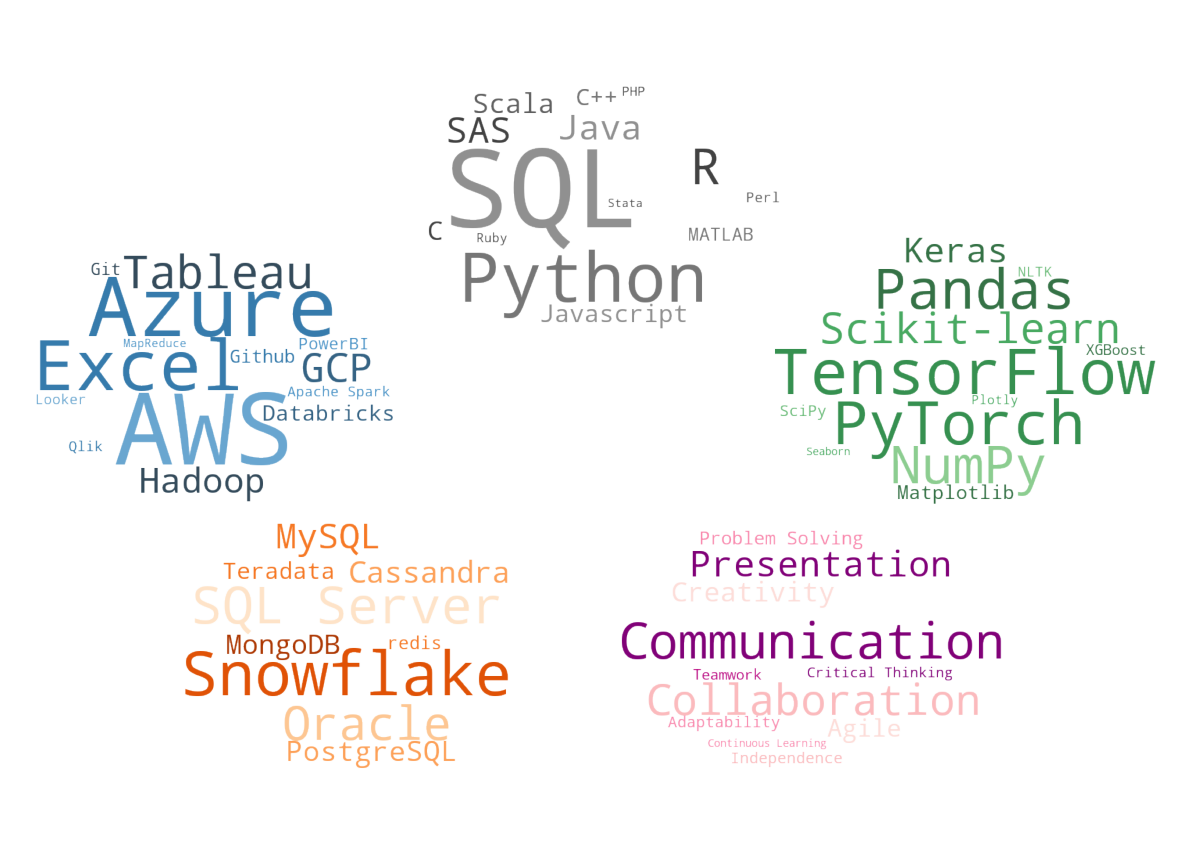

In [23]:

# title = 'Data Engineer'
# df = job_descriptions[job_descriptions['job_id'].isin(job_meta[job_meta.clean_title == title]['job_id'])]
df = job_descriptions

mask = np.array(Image.open("/home/colin/Pictures/ellipse.png"))

fig, ax = plt.subplots(figsize = (15,10))

ax.axis('off')

# you can play around with these parameters to adjust the positions and sizes of the sub-axes
main = 0.5
width = 0.40
offset = 0.25

upax = fig.add_axes([main - width/2, main + offset - width/2, width , width])


uprightax = fig.add_axes([main + offset - width/2, main + 0.70*offset/2 - width/2, width , width])
upleftax = fig.add_axes([main - offset - width/2, main + 0.70*offset/2 - width/2, width , width])

downrightax = fig.add_axes([main + 0.60*offset - width/2, main - 0.75*offset - width/2, width , width])
downleftax = fig.add_axes([main - 0.60*offset - width/2, main - 0.75*offset - width/2, width , width])

# this is last to avoid overlapping issues
# midax = fig.add_axes([main - width/2, main - width/2, width , width])

job_descs_concat = (' '.join(df['desc_stop_rem'])).lower()
# language_counts = {x:job_descs_concat.count(' ' + x.lower() + ' ') for x in programming_languages}
language_counts = kw_counter(text = job_descs_concat, kws = programming_languages)
wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)", 
                            mode="RGBA",
                          mask = mask,
                          max_words = 100, 
                          height = 400, 
                          width = 400, 
                          colormap=ListedColormap(sns.color_palette('Greys_d').as_hex()), 
                          min_word_length = 3,
                          prefer_horizontal=1,
                          min_font_size=14,
                          max_font_size=140).generate_from_frequencies(language_counts)


# Display the generated image:
upax.imshow(wordcloud, interpolation='bilinear')
upax.axis('off')


# library_counts = {x:job_descs_concat.count(' ' + x.lower() + ' ') for x in libraries}
library_counts = kw_counter(text = job_descs_concat, kws = libraries)
wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)", 
                            mode="RGBA",
                          mask = mask,
                          max_words = 100, 
                          height = 400, 
                          width = 400, 
                          colormap=ListedColormap(sns.color_palette('Greens_d').as_hex()), 
                          min_word_length = 3,
                          prefer_horizontal=1,
                          min_font_size=14).generate_from_frequencies(library_counts)


# Display the generated image:
uprightax.imshow(wordcloud, interpolation='bilinear')
uprightax.axis('off')

# dev_tools_counts = {x:job_descs_concat.count(' ' + x.lower() + ' ') for x in dev_tools + viz_tools}
dev_tools_counts = kw_counter(text = job_descs_concat, kws = dev_tools + viz_tools)
wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)", 
                            mode="RGBA",
                          mask = mask,
                          max_words = 100, 
                          height = 400, 
                          width = 400, 
                          colormap=ListedColormap(sns.color_palette('Blues_d').as_hex()), 
                          min_word_length = 3,
                          prefer_horizontal=1,
                          min_font_size=14).generate_from_frequencies(dev_tools_counts)


# Display the generated image:
upleftax.imshow(wordcloud, interpolation='bilinear')
upleftax.axis('off')


# databases_counts = {x:job_descs_concat.count(' ' + x.lower() + ' ') for x in databases}
databases_counts = kw_counter(text = job_descs_concat, kws = databases)
wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)", 
                            mode="RGBA",
                          mask = mask,
                          max_words = 100, 
                          height = 400, 
                          width = 400, 
                          colormap=ListedColormap(sns.color_palette('Oranges').as_hex()), 
                          min_word_length = 3,
                          prefer_horizontal=1,
                          min_font_size=14).generate_from_frequencies(databases_counts)


# Display the generated image:
downleftax.imshow(wordcloud, interpolation='bilinear')
downleftax.axis('off')

# soft_skills_counts = {x:job_descs_concat.count(' ' + x.lower() + ' ') for x in soft_skills}
soft_skills_counts = kw_counter(text = job_descs_concat, kws = soft_skills)
wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)", 
                            mode="RGBA",
                          mask = mask,
                          max_words = 100, 
                          height = 400, 
                          width = 400, 
                          colormap=ListedColormap(sns.color_palette('RdPu').as_hex()), 
                          min_word_length = 3,
                          prefer_horizontal=1,
                          min_font_size=14,
                          max_font_size=100).generate_from_frequencies(soft_skills_counts)


# Display the generated image:
downrightax.imshow(wordcloud, interpolation='bilinear')
downrightax.axis('off')

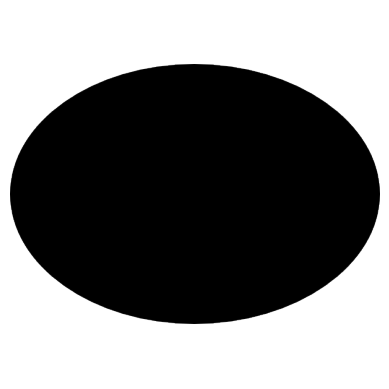

In [24]:
plt.imshow(mask)
plt.axis(False)
plt.show()